In [3]:
import os
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
from tqdm import tnrange, tqdm_notebook
from time import sleep, time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

warnings.filterwarnings('ignore')
HOLDOUT = 10
R = 0.01
os.chdir("C:\\Users\\USUARIO\\Desktop\\PIC\\PIC_AM")
os.getcwd()

'C:\\Users\\USUARIO\\Desktop\\PIC\\PIC_AM'

In [4]:
def CarregarYaleFaces():
    files = glob.glob("databases/yalefaces/*")
    images_yale = [np.array(imageio.mimread(file))[0] for file in files]
    images_yale_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images_yale]
    images_yale_resized = np.array(images_yale_resized)
    images_yale_flatten = [image.flatten() for image in images_yale_resized]
    images_yale_flatten = np.array(images_yale_flatten)
    #print('#Amostras (n): '+str(images_yale_flatten.shape[0]))
    #print('#Features (m): '+str(images_yale_flatten.shape[1]))
    Y = [f.split('.')[0] for f in files]
    return images_yale_flatten, Y

In [5]:
def CarregarAtt():
    folders = glob.glob("databases/att_faces/*")
    images_att = []
    Y = []
    
    for f in folders:
        files = glob.glob(f+"/*")
        #images = [np.array(imageio.mimread(file))[0] for file in files]
        images = [cv2.imread(file,-1)[0] for file in files]
        images_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images]
        #mages_resized = np.array(images_resized)
        images_flatten = [image.flatten() for image in images_resized]
        #mages_flatten = np.array(images_flatten)
        images_att.extend(images_flatten)
        Y.extend([f] * 10)
    return np.array(images_att), Y
    #return folders

In [6]:
def CarregarSheffield():
    folders = glob.glob("databases/sheffield/cropped/*")
    images_sheffield = []
    Y = []
    
    for f in folders:
        files = glob.glob(f+"/face/*")
        images = [cv2.imread(file,-1)[0] for file in files]
        images_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images]
        images_flatten = [image.flatten() for image in images_resized]
        images_sheffield.extend(images_flatten)
        Y.extend([f] * len(files))
    return np.array(images_sheffield), Y

In [7]:
print(CarregarYaleFaces()[0].shape)
print(CarregarAtt()[0].shape)
print(CarregarSheffield()[0].shape)

(165, 644)
(400, 644)
(575, 644)


In [8]:
def PCA(X, W, k):
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    #matriz de covariancia m x m
    C = np.zeros((m, m))
    for i in range(n):
        a = X[i].T.reshape(m,1) - mean.T.reshape(m,1)
        b = X[i] - mean
        C = C + (a * b)
    C = 1./n * C
    val, vec = np.linalg.eig(C)
    X_ = vec.T.dot((X - mean).T)
    X__ = vec.T.dot((W - mean).T)
    return X_.T[:,:k], X__.T[:,:k]

In [9]:
def FPCA(X, W, k, r):
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    mean = np.power(mean, r)
    X = np.power(X, r)
    W = np.power(W, r)
    #matriz de covariancia m x m
    C = np.zeros((m, m))
    for i in range(n):
        a = X[i].T.reshape(m,1) - mean.T.reshape(m,1)
        #b = X[i] - mean
        b = a.T
        C = C + (a * b)
    C = 1./n * C
    val, vec = np.linalg.eig(C)
    #val = np.abs(val)
    X_ = vec.T.dot((X - mean).T)
    X__ = vec.T.dot((W - mean).T)
    return X_.T[:,:k], X__.T[:,:k]


In [10]:
def Eigenfaces(X, W, k):
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    D = np.zeros((n, n))
    for j in range(m):
        a = X[:,j] - X[:,j].mean()
        a = a.reshape(n,1)
        b = a.T
        D = D + (a * b)
    val, vec = np.linalg.eig(D)
    val = np.abs(val)
    vec_c = 1. / np.power((n * val), 0.5) #eq 7
    vec_c = vec_c * (X - mean).T.dot(vec) #eq 7
    X_ = vec_c.T.dot((X - mean).T)
    X__ = vec_c.T.dot((W - mean).T)
    return X_.T[:,:k], X__.T[:,:k]

In [11]:
def F_Eigenfaces(X, W, k, r):
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    D = np.zeros((n, n))
    for j in range(m):
        a = np.power(X[:,j], r) - np.power(X[:,j].mean(), r)
        a = a.reshape(n,1)
        b = a.T
        D = D + (a * b)
    val, vec = np.linalg.eig(D)
    val = np.abs(val)
    vec_c = 1. / np.power((n * val), 0.5)
    vec_c = vec_c * (np.power(X, r) - np.power(mean,r)).T.dot(vec)
    X_ = vec_c.T.dot((np.power(X,r) - np.power(mean,r)).T)
    X__ = vec_c.T.dot((np.power(W,r) - np.power(mean,r)).T)
    return X_.T[:,:k], X__.T[:,:k]

In [12]:
def AvaliarClassificadores(X, Y):
    scores_1nn = []
    
    for i in range(HOLDOUT):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
        clf_1nn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
        scores_1nn.append(clf_1nn.score(X_test, y_test))

    scores_1nn = np.array(scores_1nn).mean() * 100
    return scores_1nn

In [13]:
def AvaliarClassificadores2(X_train, X_test, y_train, y_test):
    
    clf_1nn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
    return clf_1nn.score(X_test, y_test) * 100

In [14]:
def Experimento(X, Y):
    acc = []
    std = []
    
    n_componentes = 1
    
    #for i in tqdm(range(1, 16)):
    for i in tnrange(15, desc='Progresso '):
    
        #print('# Progresso :'+str(n_componentes)+'/70')
        
        #s_pca = []
        s_fpca = []
        s_eige = []
        s_feig = []

        #for j in range(HOLDOUT):
        for j in tqdm_notebook(range(HOLDOUT), desc='Nº c:{0}'.format(n_componentes)):
        
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state= round(time()) + 15 * j)
            #print(X_train)

            #gerar os conjuntos de treino e teste transformados
            #X_pca_train, X_pca_test  = PCA(X_train, X_test, n_componentes)
            X_fpca_train, X_fpca_test = FPCA(X_train, X_test, n_componentes, R)
            X_eige_train, X_eige_test = Eigenfaces(X_train, X_test, n_componentes)
            X_feig_train, X_feig_test = F_Eigenfaces(X_train, X_test, n_componentes, R)

            #acuracias
            #s_pca.append(AvaliarClassificadores2(X_pca_train, X_pca_test, y_train, y_test))X_eige_test
            s_fpca.append(AvaliarClassificadores2(X_fpca_train, X_fpca_test, y_train, y_test))
            s_eige.append(AvaliarClassificadores2(X_eige_train, X_eige_test, y_train, y_test))
            s_feig.append(AvaliarClassificadores2(X_feig_train, X_feig_test, y_train, y_test))

        #print(s_fpca)
        acc.append([#np.array(s_pca).mean(),
                    np.array(s_fpca).mean(),
                    np.array(s_eige).mean(),
                    np.array(s_feig).mean()])
        
        std.append([#np.std(s_pca),
                    np.std(s_fpca) / 100,
                    np.std(s_eige) / 100,
                    np.std(s_feig) / 100])
        
        if(n_componentes == 1):
            n_componentes += 4
        else:
            n_componentes += 5
            
            sleep(0.01)
        
    return np.array(acc), np.array(std)

In [15]:
def ImprimirResultados(acc, dataset_name):
    
    x = np.arange(0, 15)
    x = x * 5
    x[0] += 1
    print(len(x))
    #plt.figure(figsize=(20,15))
    plt.title("Dataset: "+dataset_name+" - Classifier: 1-NN")
    #plt.plot(x, acc_yale[:,0], color='black')
    plt.plot(x, acc[:,0], color='red')
    plt.plot(x, acc[:,1], color='blue')
    plt.plot(x, acc[:,2], color='orange')
    plt.ylabel('Acuracia media')
    plt.xlabel('Numero de componentes')
    #plt.legend(labels=['PCA','FPCA','Eigenfaces','F Eigenfaces'])
    plt.legend(labels=['FPCA','Eigenfaces','F Eigenfaces'])
    plt.grid()
    plt.show()

In [16]:
def ImprimirTabela(acc, std):
    i = 1
    for a, s in zip(acc, std):
        print(str(i)+"\t{0:.3f}".format(a[0])+" +-"+"{0:.3f}".format(s[0])+
              "\t"+"{0:.3f}".format(a[1])+" +-"+"{0:.3f}".format(s[1])+
              "\t"+"{0:.3f}".format(a[2])+" +-"+"{0:.3f}".format(s[2]))
        if(i == 1):
            i += 4
        else:
            i += 5

In [17]:
#calculando as acuracias (70 x 4)
print("---Yale---")
X, Y = CarregarYaleFaces()
acc_yale, std_yale = Experimento(X, Y)
print("---AT&T---")
X, Y = CarregarAtt()
acc_att, std_att = Experimento(X, Y)
print("---Sheffield---")
X, Y = CarregarSheffield()
acc_sheffield, std_sheffield = Experimento(X, Y)

---Yale---



---AT&T---



---Sheffield---


15


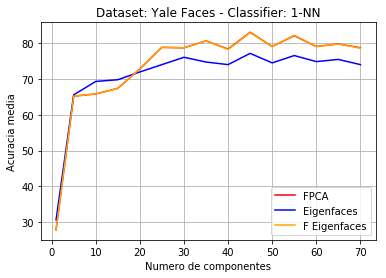

In [18]:
ImprimirResultados(acc_yale, "Yale Faces")

15


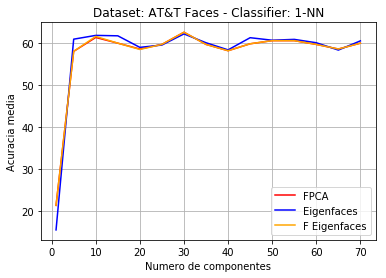

In [19]:
ImprimirResultados(acc_att, "AT&T Faces")data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYIAAAEWCAYAAABrDZDcAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAIABJREFUeJzs3Xd4FWX2wPHvSQ+kQQKhhC4dBAQFBBXshWKv66Kuoq69Arqu7OLuqusq+tMVC7aV5mLDXliCFZQiUpUWQklCSIEkJKSd3x8ziQGScBOY3JCcz/PMczNzp5w792bOvO87846oKsYYYxqvAH8HYIwxxr8sERhjTCNnicAYYxo5SwTGGNPIWSIwxphGzhKBMcY0cpYIjDmKicjpIpLk4fpfFpEHKozfKiI7RSRXRKLd1/Zebd/UDUsEfiIiSSKSLyI5IpItIt+JyE0i4tN3IiIdRURFJMjjOGu9HRG5xl320grTrnIPHrnu5y+tMJ5bYb57RSTF3TcLRCS8wnvTKixTKCJFFcY/qSSOEQduR0Q+qM3+8AcRGSIin4rIbhHJFJHFIvL7uti2ql6vqn934wgDngBGqmqEqu52X5O92LaItBWRD9zfgYpIwiHmv96d764DpqeKyHD370fceS6o8H6YL+tvyCwR+NdoVY0EOgCPAhOA6f4N6YgaB2S6rwCo6gz34BEBnAPsKBt3pyEiPYBHgDOBOOAvQGmFddxUYf6/A3MqrOOcKmLZbzuqOtqLD3ykuQewL4H5QGcgFrgVONcP4bQCQlV19eGuyMcTi1LgY+DiGqw6E5gkIhGHmGeKryddjYHtiHrAPbOaB1wGjBORPgAicp6ILBeRPSKyVUQmV1jsK/c12z3DHSoiXUTkfyKSISK7RGSGiMSULSAiE0Rku1sK+UVETnOnB4jIRBHZ6C77log0r2o7vnwmEekAnAKMB84Skfga7JJioATYoqrFqpqoqvtqsLzP3P22yC15pIjIMyISXOH9viLypXsmnioi97vTA0TkAXef7RKR2SLSzH2viYjMdPdltoj8ICJxtQzxCWC6qv5TVTPU8aOqXl7F5/mTiGxyv+PVIjKmwnvdROQrt2SxS0RmVvgsz4hT5bNbRH4WkV7ue2+KyGQR6QmsdqflisjnIhLknkl3dKeHiciT7m81TUT+7ZYiyquw3H2WCrx0qA+uqimq+jywtAb7a6U7/x3VzPOR+3pFDdbboFkiqEdU9QdgG3CSOykP+D0QA5wH3Cwi57vvney+xrhnuN8DAvwDaAP0BNoBkwFEpDvOmeTxbinkLCDJXcftwPk4B+42QBbwXFXbEZH27gGuurrh3wNLVPVtYC1wVQ12xU53+K+IhNZgudooxjloxAHDgLOBGwFEJBrnbPwDoDXQDUh0l7sb5zs5GUjA+a6ecd+7FmjiTo8F/ggU1DQwEYkETgDm1mCxX93PEQ38DZhZIQn/Decg2MyNrew7PgcYAnR137sc56y5nKquBfq5f0eo6pmVbPsJoBNwrLuujsCDFd5PACKA9sAfRSTQ/R0NqcHn88WfgHsqngQdoBT4MzDZx5JJg2eJoP7ZATQHcM+EV6pqqar+DMzCOVhXSlU3qOoXqrpPVdOBJyvMXwKEAr1EJFhVk1R1o/vejcCDqrrNPfOeDFxc1T+Jqiaraswh6oZ/D8x0/55JheohH7wFvAhsAN4rSwZuCee2GqynojbuQadsuBTAPbte7JY8NrnbLdtnY4Ctqvq0u0/3uMkanH32gKpuV9UCnH12qVvdUISTWI5R1RJVXaKqudRcc5zknuLrAqr6lnsmXaqqM3GS/SD37SKcg3NrVS1Q1W8rTI8CerjrWKOqqTUJ1P3c1wN3qmqWqu7BOSmpWHIpBiaraqGq5rv7JkZVF9VkW4eiqktxEvZ91czzDrAHJ2k3epYI6p+2uGdjIjJYnIbSdBHZDdyEc4CplIi0dKsotovIHuDNsvlVdQNwJ84Ba6c7Xxt30Q7Au2UHSZwz+BKgJtU5FeMYhnNmONudNBPoKyL9fVi2OzASmArchlM6eU+cxuLBOHXltbHDPeiUDW+52+shIh+51T57gL/y2z5uh5OMKtMe+KDCPlsJKNASeA2nJPGW+108WllSFZFxUn3jdaa7zta+fkhxGuhXVIirR4XPcw8QDCwRkZUiMg5AVT8HpgHPA2niNMZH+rpNVyucE42K2/4QZ3+USVPVwhqut1LiXABQtu9WVDLLQ8CtItKimtX8yZ3P61JnvWeJoB4RkeNxEsE37qSZwDygnapG4/yzivteZd3G/sOdfqyqRgG/qzA/qjpTVYfjHPgVeMx9aytwzgEHyjBV3V7Fdg5lnLvdn9z64MXudF+udAnCKbqXqGqpu65S4CdguaquqUU81XkBWIVz9h6FU2VQts+2Al2qWG4bcEYl+yzVPeOdrKo9geHABVRSNaaqr1fXeK2qOcAPwEW+fBAR6YxzML8ZiFXVGGBd2edxSwrXq2pr4BbgRRHp5L43VVWPA/oAvXCqvmoiDSgEulfYH9Hu77b8I9VwnVVyS8tl+65fJe+vxqnSm1TNOj4BknGrAhszSwT1gIhEicgonDPoN1V1pftWJJCpqgUicgJwZYXF0nEOkJ0rTIsEcnEadttSoWgsIt1F5FS3mqUAyMc56wcnwfxNnAZeRKSFiIytZjvVfZYw4FKcRuL+FYbbgKt8qJNdB6wH/u3W0QcDn+PUz5eIiFS3cC1EAruBPLdBtOJBYR7QXpxr50Pc7+kE971pwN/L2knc0tgY9+9TRaSPW12yB6fqpYTauQ+4XkTuFrcBX0QGlDX0HiAC52Cb7swm1+NW97jLXer+LgCy3XlLROQEdwjCaesorGm8qloCvAxMdX8/IiIJIlJZW4LP3N9T2Rl7aA3bjCYDN+B8x1V5EOdqvUbNEoF/fSAiOThnng/i1OlXrLP8I/BXd54/49SdA6Cqe3Ea/76t0OD2F+A4nAPbR8A7FdYVinOJ6i4gFafIXnaj0NM4B73P3W0twqmGqXQ7bmNxVTcSnY+TZN5wz45T3frm6UAgTmNsldwDyiicBvKNOEnheKCv+9keqW75WrgHp9SRg1M6mFMhlt3AGThn5DtxGmLL2g+eBD4F5rv77Ds3TnAa3MvqoFfjVBPNqk1wqvo1cDpu476IZOKc9X9cybw/4zRY/4DTrtCD30pj4HynP4pInhvfLW47TwzO95ON06aQAjxVi3DvAba429+Nk8C7VjWz21hc5ZVobmLKd+MCp5ouz9dg3OrQWTgN91XNs5CaXZXUIInag2mMMaZRsxKBMcY0cpYIjDGmkbNEYIwxjZwlAmOMaeSOitur4+LitGPHjj7Nm5eXR9OmTb0N6AiyeL1l8XrL4vXW4ca7dOnSXapa3U11DlWt98PAgQPVVwsWLPB53vrA4vWWxesti9dbhxsvTn9fhzzGWtWQMcY0cpYIjDGmkbNEYIwxjZwlAmOMaeQsERhjTCNnicAYYxo5SwTGGNPIWSIwDVNJMcydQIefXoXSUn9HY0y9ZonANDyf/AueiYLCx+nU8g14KgYWvOjvqIyptywRmIZj6fvwz5aQdS+Fwcpznz/J0x88xL6mRZByI/yzHaz+n7+jNKbeOSr6Gmpoioth/XpYuxaWL2/Jrl0QFATBwYceqpvviD/E8WiR9BPMvQJaraOkWSAz/ncv49+YQliTMFSLePDd+/nbRVO4+fSnCF56GvJZf7jiLWhd5cOzjGlULBF4qLQUkpJg9WpYteq3Yd06KCyEY9uvICuvGVszjsz2AgOdhBASAmeeCX/9K/TseWTWXS9lp8J/LoemC9GW8NHiK7nmtacpCohjwiS46y744YfvyMw8hRdeeIzH7r6DKRc/xDWnvEbpR70ILDyTgHEzoGmMvz+JMX5lieAIUIUdOw4+4K9eDXv3/jZfhw7Qpw9ccF42V/e6gy4BbwCQH9af7IgxZISNYXfAcRQVC0VF7DcUF3PQtKqG3bth5kx45x24+mqYPBl87Lz16FBYADPGw74ZEFvK9z+P5OrXXmTn3mO44064+25o1syZNSREufxyuPxy+PXXNrz00nRG/OM2Jp77IOcN+JjsVzpD2NXEXPcvCGyY/w6qUFLilCaNqYz9NGpo166DD/irVkF29m/zxMc7B/wbbnBe+/SBXr0gKgrY8Sl8fx3kp8J7QB6En/QL4e2m0Fr+CqGtoN1YaDsGWp0KgWG1ivORR+DRR+G555ykMH48PPggtG59RHaDf5SWwry/wpZHocU+ftnei2uffImVKSdy++1wzz3QvHnVi3frBv/8J+x7pD/vvfcR98x8l98N/isDYp9hw+OfktXkPgbedj0BDajlbP58uP9+WLYMWrWCdu1+G9q333+8VSunVGkaH0sEh6DqHFQXLnQO+Glpv70XE+Mc5C+//LcDfu/eEBdXyYqKcmDx3bDxZUgJhGkBcOE9bNy9my4Lt8Dyr6DrXhiYCv1fgg0vAGHQ6nToeBG0OQ/CDt2teJkWLeBf/3KqRx55BKZNg1degdtvdw4M1R0w66XvZsC3t0LbbFJLW3PL1P/jszUXcNttAcy7p4p9XoXQULjsMrjssgv4de1oZj37T07q/hzHx93A/ElvsVEeYvQdJx3VSXP1aud7/vhjpyQ6aRLs3AnJybBmDXz2GeTl7b9MUBC0bVt9soiNPby2qNJSyM93Ssplr2VDxfHAQOja1UneR9HjA45alggOITUV/vxn50d5zjm/HfD79IE2bXz8p0hbAF9fDQXb4SNg2yB45yXo25etiYl0GTHCaTT48UdYsABmfAFZ30PfAhj4IaR+CAqE9IZul0PHiyGqu08bT0hwksC99zpVRI8/Ds8/D/fdB3fcAZGRh7d/PPfr9/D+VdB2MzlRkTz4+tO88f2N3HhzKNM+chLe4ejWM4huz01iX8aNrJh6B4O7vsuIsBG88tAfWJT1AJeO78gZZ3DUlBJSUpzf6yuvON/tP/8Jt94KYQcULFWdUmxyMmzduv+QnAyLFsHcuU5VY0Xh4b8lhc5tcwjOhy9mriO/QMgvEAr2CfkFkL+v4rhQUDYU+rYj9xY2ITM3FnB+w927Hzy0b3/0fC+1VVhYN1eAeJoIRCQGeBnog3Mouw74BZgDdASSgEtVNcvLOA5Haqrz+thjcMEFNVy4OA+W3gcbn4dUgTeawI1PwI03HvwLDgmBYcOc4U9/ck6Pvv8eFvwPvvgAQlZC/9VQ9BCsfggKm0PsGXDcDdD6FAio/qs85hh4802YMAEeesgZnnkGHngAbrrp4AOF36VvgRmXUdrsB4pbBPHkvAlM/WIiV18Xw6//gZYtj+zmQmOb02/Kf2D7WrJev5brTp7OlcUzeOyFCdx161387tpIrr22/lat5ebCE084B/6iIqfk96c/OWfwlRFx2lGaNYN+/Sqfp7QUdm7KJP3HxeRuWknx7o0E6TYim6YQF7uDls12EhCgnn2mgj1hpKR35Nddx7J0xwkkfnM8b77ajz350YDzm+3atfIkER3tWVh1YtUqp1p3xowT+eUX7393XpcIngY+VdWLRSQEaAI8AMxX1UdFZCIwEZjgcRy1VpYI4uNruGD6t7DgcijeBp8AxefDJ8/5/o2Gh8OppzoDj0BODnzzDXz9HqR+Ci2SodccWDgHCoKhpA90uQSG3gThzapcbd++8N57sHix02Zw111OFdLDD8M119SDBsWCXHhjHCW8j8SVMuPbq5jy/hRGX9GRFWtq8T3UVNueNHtgEaz8grBPruWvFz/M7ac9w8S5j9Lh4WsYNTqIG2+k3pQSiouds/+HH3Z+q5deCn//O3TpUoOV5GbCuoWQ9AOk/wx5m4BUAprk0CqmhFYAncrmFchpCgUtIWsEqXnBtGrlwVGqIIuw3LV0arqVTm3Xcdbgt3ig/K1wdmZ2ZGNWP35KO56vNg3h6Y/6kZv/Wx1SfHzlCaKkpP5eY11U5PxvPvssfPWVU4U5cuQuioq8P/vw7N9eRKKAk4FrAFS1ECgUkbHACHe214FE6nEiKGsTaNXKxwWK8+HH+2DTc5AOvNcS7p0Oo0YdXiCRkU7d1DnnOONZWZD4Kaz4D+z7Hjouh9Tl8NYDsKsFRAyH42+AAWdXWoU0eDB8+aXTmPjgg07D9uOPO5ecXnqpHw5ypaUwdwJFqc8RHJdP4qpTeeC/jzP0vIEsXOqHM/G+ZxDYdxvMf564lPt5+YYbmHLeZO5659+cffZo2rQRLrwQLroIhg+v+wSq6tT/33+/U+c/bBi8+y4MGVLFAlUc7GmSAzElv80XDQS6B/u8DlDSAWJ7Q/vjodtJ0LLTfqtdl5hIqxEjPPqUrpJiWL8I1n4OKT8QtvcX2kdspn37tYwMns1dgJZCUWYTMnZ3ZHPOsazMGMI3W4fy4bx+vJQWWr6qsLDhjB0Ll1zi/Cs1aeJt6L5ISYEXX3SGHTugUyd4/s8r+V2b/yNw5weEx6wEatAIVgviPNbSgxWL9AdeBNYA/YClwB3AdlWNqTBflqoedAorIuOB8QDx8fEDZ8+e7dN2c3NziYiIOPwP4Jo5sz0vvdSZjz/+ivDw6vusidy3hj47/kxoaAY6H7bnX8Dmq2+gJDzc83iDM9Jp8+tHtNj7NU3ikgloUQxA6c4A8ne1JSN8MDu6nk9By7YHLasK330Xy/Tpndi8OYLOnXO5/vrNDBmScVAOOdL7N3RPGq02fkLLfe/RtP1uVm3txQNvPUZQh35ceeVW4uIKD2v9RyTe0lK6LJ9G2+B3CIgrYcfGDjy+6G+8tOBi9uaHEhNTyLBhuzj55F0MGJBFcHDt/6d8iffXXyOYNq0Ly5c3IyFhL+PHb2L48F37f1elpcRt+Ya2294lqslaAlvv228dmiOU7A6jqCCGAmlFXlgHcmJ6kt3qWPZF+nrWc+R/DzUhxYXE7FhOs/RlRO79lXDZRkhENhJbjLhXP2kxFO8KIz07gU17evP19uH8Z/GFrN3ambCwEoYOzeCUU3YyeHAmYWF11yeVKvz8czTvvdeWr7+OIyJ0D388dSa/7/063VovK///1T3C6tDJ7Op0cq22M3LkyKWqOuhQ83mZCAYBi4BhqrpYRJ4G9gC3+ZIIKho0aJAuWbLEp+0mJiYy4gieodx5J0yf7tTMVKlkH3xzN2z9N2QCC7vCn+bAgAGHXP+Rjrfcuq9g0QuQtQCapUAIUAgkN4WggdDrCjj1SveaVkdpKcye7TQ2btwIQ4c61QwVwzucePPS95I2fwH5674gqGA5Mc030KJNCgEByo6s1vz13cmEdLuGCQ+G0PbgfFUrR3T/FuTCG78HeQ+aKrpX2La9Lx8lXcUTn1/Fxh1tiYmB0aOdksKZZzo1fEcq3i1bnNLbjBnOVVIPP+w0NwUHuzMUFcLCl2HlKxC8ApoXQymQFgkhx0FsX+fMvvsp0KLD4ewJn+L1m7xsWPU5bFwI6cuhcBOEZzj7w1WQHc66HQP46JczWLB2OGvTBnLSac08Lynk5jrf34vP5xNZuJhR/T/hkr5v077dRiQAKAAyWkLUiTDw9yTuiWbEqafWensi4lMi8LJAuw3YpqqL3fG5OO0BaSLSWlVTRKQ1sNPDGA5bWtohqoV2/gCfjIXgVPg+CLpPgbfu8/8F2T1OdgaAwjz48Q1YMwtaLIXor2DvVzD9ZkhrBc1HwuBrCRh6CldeGcIll8CrrzrVRCNHOvXhf/sbHH985ZsqKXH20/btzrBjB2zfWkrq2l2E5/5AQtRSurdbwQldF9O5+Q7oBjn5ESzaMISlS69h/a7BRHY7hQdfjaZdu7rbRTUWFgHj34GMbfDlk0j2h7SLX8VNXSdw0xkT2L2jBV8ljeLf3/6ei2YMJyw8iHPPdZLCuefW/gqt7Gz4xz/g6aedWr6JE50hOhrnoPfRVNgwCyLXQ6RCc2BnC9h3Npx6L3Q49kjuhfqvaQwMvtQZKspO5ZfZj9M9IImwvOX0j/+R/r2+40H3IpANKV34fv5QHn5lAKFRvRk4eihnnR91RJLCL2uKee/pr9mT+gMn9VjAN3csJDy0AC0B2RkJmSdDr0tg+DXO76xMYuLhb9wHniUCVU0Vka0i0l1VfwFOw6kmWgOMAx51X9/3KoYjITW1ikRQWgSf3wLpL0EusPIEeHAu9fJIFtIUht3sDAAZa2HRNMj5CHpuhuBZsHkWfBYIBd0I7nQB40dewdW/9ub5acI//gEnnOBcNRUb2565c/c/6KemKiUlQvOIDIZ2/Z4Tu37HWd2+4fixPxIeWuBsMqsFqRl92Lbnd0iXs4gedjJDLg3ijPp++WplYhPgsieBJ51i1A//haXTiZbFjB78KqNPfJWivGB+3jyE/yy7kjtvGsu4/NacdZaTFEaP/u3O5+oUFjqX+k6ZApmZzl3ijzwC7cK2wEePw/b3IXY7hAHNgMz2EH0hjLrHidHsL6YVKT3G0L1iCWbnZvhxDmyeT+eS1bTrO5erh78JQFFxEKue6kN6eheaN+tM79NOJHzwuRAc4tPmStZ9z89vvU32ntX07rKUCaekA7B3ZxRhmd2h82jk5BvrxXfldRPXbcAM94qhTcC1OD2eviUifwCSgUs8juGwpKY6N4ntZ9si+HgMRKTDz+EwdBrc8nu/xFcrsT3hvKeBp6GkADZ9BMtfgy7fQPhaYC18/nfCNzTh7tATuGHK1UzdcBFPvBTNnj2diYkupW10LkNaf89Ngz6nX+tv6Nz5V5q1dW6v1hKB/JZIyCnQ+RzocyGxEe2o4krGo1tAAAy5zBnAuez1f08TvPtDBrb7loF9vmbq729m27YOvLfqQl76+wWMv2EIp4wI5qKL4PzzD74UVhXefts569+4EU47DabevYI+KY/C7C8gPsP5z40MgMye0O1KOP92aBJ1UHjmEFp2gvOcixcDgFCATUsoWTKX7etXEE4KQ/p8TlSTHEiGgl/DyElrSUxIa4ITToR+F0K3E53fwc7NsPB58jd9QX7oNpq33MWAYyAtK57UbT0JDbiE6DOupUnnQ9bU1DlPE4Gq/gRU9qlP83K7R1JamvOPCEBpMcy9FgrehBLgl3Pgodn71bMfdQLDoOtFzgCQuwlWzYCSudBiNQQmElmYyEOBf2Di2NYUFhfQtE0WdAXKzuaLQoBu0OIq6HU+En8iBNWDyzH8oUWHSkoLr5AQsIhbzniKW89+ivy9YSxYcwb/nXEBf5l4Fsf0bcNFF8GFF8KqVVE88IBzC8nooSv46OrH6BYxD8nOg3AgLBgyT4B+f4DLrmuw/SP5VedBBHYeREd3tHhfMYtmf8Pa736guHgTfTv8xIA2y6FkMSx7Cl0YAHtDoEUBEgDFcRF8u3YEyUsH0m3wSYwcP5L4kHpwrXE17FdUjX37nKs0W7UCfkmEzy+E2CzYGA1nz4GhZ/k7xCMvojMMecgZSgogbSGsfBMCPiO4XwrBAEUtIHoQdD0PEk5173Ku3z90vzigtCDpW2DBM4Rnf8A5XT/i3EEfALA2uSfvfns+V/z7HAqLQ/jd0Lv5+JI3iIl3u6VNbQJZZ8DQW6H/qPpxA0MjEhQaxJBxIxgybgTFxc41/vfMyeeXxT9zTNwyhh6ziC5xm/n8m9P4bv0Iep08mJtuCWP0UdTzryWCapTdQzBi713w/VSn3Jh5JTz4qnMncEMXGAZtznIGgLxkvl20nGGnjfVvXEerFh3g0n8B/0JKS+HHubD0FXoGLaLHqH/wwNh/ADgNiGnNYO8lMOIeOGawf+M25YKCyu7zDKekZDBffTWYt966melfO/1XvfPaUdBtSyUsEVQjLQ3iItMZ3mcqbI+BsZ9BtxP8HZb/NG1PUeAmf0fRMAQE7Hdli+xKhv/9H9uS1pPw+39Bq5rcGmz8ITDQuapu5Eh/R3L4LBFUIzUVOsRtcUY639y4k4DxVlx7uPSfbEhMJMGSgKljVtlYjdRUaB+b7Iy07uPfYIwxxiOWCKqRlgbtYrc6Ix2P828wxhjjEUsE1UhNha7xm5yuGVp183c4xhjjCUsE1UhNhWPiNkFOsF2yZ4xpsOzoVo20NGjXbAvs80/visYYUxcsEVQjNRVaxewAbZCdIxhjDGCJoFq7dhbSLCYTQuvp8wmNMeYIsERQhbw8iApx+sonsqO/wzHGGM9YIqhCWhq0a+5eOhrX3b/BGGOMhywRVCE1FdrHuTeTte3r32CMMcZDlgiqkJpaoUTQqf71H26MMUeKJYIqlN1VXLo3AJq18Xc4xhjjGUsEVXD6GdqC5DaC7qaNMY2aJYIqpKZCp7gtSNFR2Lm4McbUgCWCKqSlQULzrRDQwt+hGGOMpywRVCFrZw7NIrMhrK2/QzHGGE9ZIqhC4F73gTTRnf0biDHGeMwSQSVUIUy2OyMte/g3GGOM8Zglgkrs2QOtot1EkNDfv8EYY4zHLBFUIjXVnkxmjGk8LBFUoqyfoX17QqFJlL/DMcYYT1kiqERZP0MluU39HYoxxnjOEkElyvoZCiyxm8mMMQ2fJYJKpKWW0i52KyHBzf0dijHGeM4SQSVyUtKICMtDmrTzdyjGGOM5SwSVKM3a5PzR/Bj/BmKMMXXAEkElgorcS0fje/k3EGOMqQOWCCrRJDDF+aP9AP8GYowxdcASwQFKSyG6aSolxQHQzh5RaYxp+IK8XLmIJAE5QAlQrKqDRKQ5MAfoCCQBl6pqlpdx1ERmJrRttp283ZFEBQX7OxxjjPFcXZQIRqpqf1Ute/DvRGC+qnYF5rvj9UZamnMzWUFutL9DMcaYOuGPqqGxwOvu368D5/shhiqV3UymxTH+DsUYY+qEqKp3KxfZDGQBCrygqi+KSLaqxlSYJ0tVm1Wy7HhgPEB8fPzA2bNn+7TN3NxcIiIiah3zl5834889jmfHL/1JOuPxWq/HV4cbb12zeL1l8XqrscU7cuTIpRVqY6qmqp4NQBv3tSWwAjgZyD5gnqxDrWfgwIHqqwULFvg8b2Wm/WWt6gw077krD2s9vjrceOuaxesti9dbjS1eYIn6cKz2tGpIVXe4rzuBd4ETgDQRaQ3gvu70MoaaKkzbAEB46y5+jsQYY+qGZ4lARJqKSGTZ38CZwCpcYvj/AAAgAElEQVRgHjDOnW0c8L5XMdRKnnMzmbTu7edAjDGmbnh5+Wg88K6IlG1npqp+KiI/Am+JyB+AZOASD2OosWCnEAMdD12tZowxDYFniUBVNwH9KpmeAZzm1XYPV9PQVAr2hRLWspO/QzHGmDphdxYfICZiJ9lZsRBgu8YY0zjY0a6CkhJoGZNCbq49h8AY03hYIqggPR3ax26lqNASgTGm8bBEUEFach7x0WloQEt/h2KMMXXmkI3FItIV+AfQCwgrm66qnT2Myy92r11NQLASHNHG36EYY0yd8aVE8CrwPFAMjATeAP7jZVD+snfrOgCaturo30CMMaYO+ZIIwlV1Pk6/RFtUdTJwqrdh+UdRdjIA0V17+DkSY4ypO77cR1AgIgHAehG5FdiO03dQgxNQ6NxM1rS33UxmjGk8fCkR3Ak0AW4HBgJX81sXEQ1KaGAaWTkxENXC36EYY0ydOWSJQFV/dP/MBa71Nhz/ahqezq7slhzUJ7YxxjRgVSYCEZmqqneKyAc4zxPYj6qO8TQyP2genU72HisNGGMal+pKBGVXBj1RF4HUB/HNU0jdaQ3FxpjGpcpEoKpL3deFdReO/+xLSyWm6W6KtUG2gxtjTJWqqxpaSSVVQmVU9VhPIvKTzBXLaQ0Q3tbfoRhjTJ2qrmpolPt6i/taVlV0FbDXs4j8JGfTOlpHQWhsR3+HYowxdaq6qqEtACIyTFWHVXhrooh8C/zV6+DqUn76FoiCiE7WRmCMaVx8uY+gqYgMLxsRkROBpt6F5B8le1MpLRWa9e7j71CMMaZO+XJn8R+AV0QkGqfNYDdwnadR+UGg7CQluzXx7Zv4OxRjjKlTvtxQthToJyJROP0N7fY+rLoXFprBjsw2tA079LzGGNOQHLJqSETiRWQ6MEdVd4tIL/fB8w1KZGQGu3a38ncYxhhT53xpI3gN+Awo66T/V5z+hxqO0lJim6ezJ8/uITDGND6+JII4VX0LKAVQ1WKgxNOo6lrqekJDCikojvd3JMYYU+d8SQR5IhKLe3OZiAzBaTBuOLYsA6A4yG4mM8Y0Pr5cNXQ3MA/o4t4/0AK42NOo6ti+LasJBQKjO/g7FGOMqXO+XDW0TEROAboDAvyiqkWeR1aHclK3ENoSwtp283coxhhT53x5eH0gcC7Q0Z3/TBFBVZ/0OLY6sy8nlX3NQojq1NnfoRhjTJ3zpWroA6AAWInbYNzQaOkutmUm0KqvL7vDGGMaFl+OfAkNrafRAwWGZLM1owPd7DYCY0wj5MtVQ5+IyJmeR+JH4RG7Sc5oTwt7OJkxphHypUSwCHhXRAKAIpwGY1XVKE8jqytFhUTG7CZjTzzBwf4Oxhhj6p4vieBfwFBgpapW+aCao1byCgIDS8kpsJvJjDGNky9VQ+uBVQ0yCQAkLwegQO1mMmNM4+RLiSAFSBSRT4B9ZRMbzOWjqasBKA1v7+dAjDHGP3wpEWwG5gMhQGSFwSciEigiy0XkQ3e8k4gsFpH1IjJHREJqE/iRotkbAQhqcYw/wzDGGL/x5c7ivxzmNu4A1gJljcuPAU+p6mwRmYbz4JvnD3MbtVaYm8K+kEii21rPo8aYxsmXEkGtiUgCcB7wsjsuwKnAXHeW14HzvYzhUIqKs9ia0Y5WrcSfYRhjjN+Il23AIjIX+AdOVdK9wDXAIlU9xn2/HfCJqh70oGARGQ+MB4iPjx84e/Zsn7aZm5tLRESEzzEO+OEivs84nlUtHmPQoCyflztSahqvv1m83rJ4vdXY4h05cuRSVR10yBlV1ZMBGAX82/17BPAhTs+lGyrM0w7nstRq1zVw4ED11YIFC3yeV1U1//kwfeEPN+iKFTVa7Iipabz+ZvF6y+L1VmOLF1iiPhyvfel0LgynHr83UP5EX1U91APshwFjRORcd7koYCoQIyJB6jzgJgHYcchs5ZW8bMKiCtia0Y7zrXsJY0wj5UsbwX+AVsBZwEKcg3fOoRZS1UmqmqCqHYHLgf+p6lXAAn57nsE44P1axH1kbF4KwPastsTG+i0KY4zxK18SwTGq+hCQp6qv4zT+9j2MbU4A7haRDUAsMP0w1nV4tq0AILewNYGBfovCGGP8ypcbysoeQpMtIn2AVJxnE/hMVROBRPfvTcAJNVneMzvXQhDsk3b+jsQYY/zGl0Twoog0Ax7CeWRlBPBnT6OqK3s2Q3MgqqO/IzHGGL/x5Yayl90/FwIN6xFeBdvJ2NOc5q2OnsvJjDHmSKsyEYjI71T1TRG5u7L3tQH0NaS6iy0ZHYi3jkeNMY1YdSWCpu6rz/0KHW1KgvNITmlPK+tvzhjTiFWZCFT1Bff1cPsaqrckstDpXqJ+NF0bY4xfHPLyURF5XURiKow3E5FXvA2rDuxKJjC8hOSM9lY1ZIxp1Hy5j+BYVc0uG1HVLGCAdyHVkSTnZjKnwzk/x2KMMX7kSyIIcC8fBUBEmuPbZaf1246VAGzNtERgjGncfH1m8XduT6IAlwB/8y6kOrLrFwiD1D3tiIk59OzGGNNQ+XIfwRsishQYCQhwoaqu8Twyr+VsoTREKA1tjdijCIwxjZhPVTyqulpE0nF7HxWR9qqa7GlkXitMISM7jhYtg/0diTHG+JUvVw2NEZH1OM8uXggkAZ94HJf3JJPtme3siiFjTKPnS2PxFGAI8KuqdgJOA771NKq6EJpLUmYHayg2xjR6viSCIlXNwLl6KEBVFwD9PY7LW6WlaFQxG9I7WyIwxjR6vrQRZItIBPAVMENEdgLF3oblsR1rkWDYsqsD3Yf6OxhjjPEvX0oEY4G9wF3Ap8BGYLSXQXnObiYzxphy1ZYIRCQQeF9VTwdKgdfrJCqvpa4GLBEYYwwcokSgqiXAXhGJrqN46kbmBgDrZ8gYY/CtjaAAWCkiXwB5ZRNV9XbPovJa3haKQoLYlRNnJQJjTKPnSyL4yB0ajuKdZGc3p0kTIcIeTmaMaeR86WKiYbQLVBSQRVr2McTHY91LGGMavUMmAhHZDOiB01X16H1+cfhetm+zm8mMMQZ8qxoaVOHvMJzeR5t7E04dKCyAqFI2Z9rNZMYYAz7cR6CqGRWG7ao6FTi1DmLzRtJyCIBf0o6xRGCMMfhWNXRchdEAnBLC0ftA++TlAKxN6cxQu6vYGGN8fjBNmWKcXkgv9SacOrBzLeDcTHaBlQiMMcanq4ZG1kUgdSZ7I8TYIyqNMaaML88j+LuIxFQYbyYij3gblofyt1G0N5ic/Ci7q9gYY/Ct07lzVDW7bERVs4BzvQvJY6Xp5Ox28pqVCIwxxrdEECgioWUjIhIOhFYzf/0WtJvMnNYAViIwxhh8ayx+E5gvIq/i3Fh2HfCGp1F5qWkBqdvbExUF4eH+DsYYY/zPl8bix0XkZ+B0QIApqvqZ55F5Yc8uiFC25djNZMYYU8aXEgGq+inOQ2kQkWEi8pyq3uJpZF5wH0izMbOrJQJjjHH50kaAiPQXkcdEJAl4BFjnwzJhIvKDiKwQkdUi8hd3eicRWSwi60VkjoiEHNYnqIltKwBYl36MtQ8YY4yrykQgIt1E5M8ishZ4FtgGiKqOVNX/82Hd+4BTVbUfzsPuzxaRIcBjwFOq2hXIAv5w2J/CV+lO/lqZbFVDxhhTproSwTrgNGC0qg53D/4lvq5YHbnuaLA7KE4/RXPd6a8D59c46trakwTA2q3W86gxxpSpro3gIuByYIGIfArMxmks9pn7zOOlwDHAczgPvs9W1WJ3lm1A2yqWHQ+MB4iPjycxMdGnbebm5lY57wlZ6wkJCqKwOJSsrHUkJqb6/mE8Ul289ZHF6y2L11sWbxVUtdoBaApcBXwI7AWeB8481HIHrCMGWACcBGyoML0dsPJQyw8cOFB9tWDBgqrffDxWc/4Zq6D64Yc+r9JT1cZbD1m83rJ4vdXY4gWWqA/HaF+6oc5T1RmqOgpIAH4CJtYw2WQDicAQIEZEykoiCcCOmqzrsITksGevUydkVUPGGOPw6aqhMqqaqaovqOohn0cgIi3K+ihy70Y+HViLUzK42J1tHPB+zUKupdJSiCwko6A9YHcVG2NMGZ/uI6il1sDrbjtBAPCWqn4oImuA2W7HdcuB6R7G8JtdWyAMUvK7ANCyZZ1s1Rhj6j3PEoGq/gwMqGT6JuAEr7ZbJfdmsi153YiNhZC6u3vBGGPqtRpVDR3Vtv8MwMbsblYtZIwxFTSeRJC5HoA1O617CWOMqajxJILcLVAMa7e1t0RgjDEVNJ5EUJiC5gSyIyXIEoExxlTQeBKBZFGSH8nevXbpqDHGVNR4EkFYHvmFdjOZMcYcqHEkgpJiiComu8S5mcwSgTHG/KZxJIKtqyAIdhUfA1jVkDHGVNQ4EkHycgB2FPUArERgjDEVNY5EkLoKgKT8ngQEQFycn+Mxxph6pHEkgqyNAKzf3ZMWLSAw0M/xGGNMPeJlp3P1R95WCIFNu1pbtZAxxhygcSSCkjTICSE1NcASgTFHSFFREREREaxdu9bfofgsOjq6QcYbFhZGQkICwcHBtdpO40gEgdmwL4LUVOjZ09/BGNMwbNu2jfj4eBISEhCp0VNs/SYnJ4fIyEh/h+EzX+JVVTIyMti2bRudOnWq1XYaRxtBeD5KLGlpdsWQMUdKQUEB0dHRR00SaKhEhNjYWAoKCmq9joafCApyIbKUgsD2FBZaIjDmSLIkUD8c7vfQ8BPB5mUQAFkBXQG7mcwYYw7U8BPBthUA7AzoA1iJwJiGJDAwkP79+5cPSUlJJCYmEh0dzYABA+jZsyd/+ctfyudfsmQJJ598Mt27d6dHjx5cf/317N27t/z9sWPHMnToUH98FL9q+I3FaWsgALaXWiIwpqEJDw/np59+2m9aUlISJ510Eh9++CF5eXn079+fUaNGkZCQwLhx45gzZw5Dhw5FVXn77bfJycmhSZMmZGdns2zZMiIiIti8eXOtG16PRg0/EezeBM1gc1FfwKqGjPHEnXfCAQfkw9a/P0ydeliraNq0KQMHDmTjxo28//77XHHFFeVn/CLCxRdfXD7v22+/zejRo4mPj2f27NlMmjTpsLZ9NGn4VUMF2yFP2JbRnOBgaNbM3wEZY46U/Pz88mqhCy644KD3MzIyWLRoEb1792bVqlUMGDCgynXNmjWLK664giuuuIJZs2Z5GXa90/BLBKXpkBtKWppTGgho+KnPmLp3mGfutVVZ1RDA119/zYABAwgICGDixIn07t272vWkpaWxYcMGhg8fjogQFBTEqlWr6NOnj1eh1ysN/7AYvAeKo0hNtWohYxqLk046ieXLl7N06VJuuukmAHr37s3y5csrnX/OnDlkZWXRqVMnOnbsSFJSErNnz67LkP2q4SeCpvsgoAWpqdZQbExjduuttzJr1iwWL15cPu3NN98kNTWVWbNm8emnn5KUlERSUhJLly61RNBgZKdCU4XwBLur2JhGLj4+nldeeYV7772X7t2707NnT77++msyMzNJTk5myJAh5fN26tSJqKio/ZJGQ9aw2wg2LwGgNKoLO3da1ZAxDU1ubu5B00aMGMGIESMqnX/w4MF8/fXXB03fvn37QdOWLVt22PEdLRp2iWD7SgB2N+lNSYmVCIwxpjINOxGkrwMgLfQ4wBKBMcZUpmEngpwkKIVt0g+wRGCMMZVp2G0EhSmQE0CKhgPWRmCMMZVp2IlAMyA/nLQ8Z9RKBMYYc7CGnQiuWwFZ20mdBuHhcBQ9mMgYY+pMw24jiE2AYwaX31Vsz9AwpmE5sBvqRx99FIDrr7+eNWvWHPHtPfPMM/Ts2ZOrrrrqiK/bnzwrEYhIO+ANoBVQCryoqk+LSHNgDtARSAIuVdUsr+IA7GYyYxqoqvoaevnllz3Z3r///W8++eSTBtdFtZdVQ8XAPaq6TEQigaUi8gVwDTBfVR8VkYnARGCCh3GQmgrHHOPlFoxp3OpbL9QjRozgiSeeYNCgQUyfPp3HHnuMNm3a0LFjRyIiInj22WdJT0/npptuIjk5GYCpU6cybNgwJk+eTHJyMps2bSI5OZk777yT22+/nZtuuolNmzYxZswYrrvuOoYNG8add95Jfn4+4eHhvPrqq3Tv3p2SkhImTJjAZ599hohwww03cNttt7F06VLuvvtucnNziYuL47XXXqN169Y888wzTJs2jaCgIHr16uWXri08SwSqmgKkuH/niMhaoC0wFhjhzvY6kEgdJIJhw7zcgjHGH8q6oS4zadIkLrvssvLxHTt2MGXKFJYtW0ZkZCSnnHIKxx3n3Fd0xx13cNdddzF8+HCSk5M566yzWLt2LQDr1q1jwYIF5OTk0L17d26++WamTZvGp59+yoIFC4iLi2PPnj189dVXBAUF8eWXX/LAAw/w9ttv8+KLL7J582aWL19OUFAQmZmZFBUVcdttt/H+++/TokUL5syZw4MPPsgrr7zCo48+yubNmwkNDSU7O7tud6CrThqLRaQjMABYDMS7SQJVTRGRllUsMx4YD04fIYmJiT5tKzc3d795i4uFjIyTKSjYQmJiUq0/g1cOjLe+s3i9dTTFGx0dTUlJCTk5OUyZ4s02cnKqfz88PPygLiNycnIoKSkhLy+PhQsXcuKJJxIcHExBQQFjx45l48aN5OTk8MUXX7Bq1ary5Xbv3s2OHTvYt28fp59+OoWFhYSGhhIXF8fGjRtp27Ytqkpubi6hoaFs376d+++/n40bNyIiFBUVkZOTw6effsp1111Hfn4+AMHBwSxbtoxVq1Zx2mmnAVBSUkJ8fDw5OTn06tWLyy67jPPOO49Ro0YRGBhYHlPZ/vVFQUFBrX87nicCEYkA3gbuVNU94mOLraq+CLwIMGjQIK2q75ADJSYm7tfPyI4doApDhnRkxIiONYq9LhwYb31n8XrraIp37dq1BAYGEunny/Eq235gYCBNmzYlLCyM4ODg8nlEhJCQECIjI1FVFi9eTHh4+H7LhoaGEhERUb5McHAwYWFhREZGIiLl7z322GOcccYZfPDBByQlJTFixAgiIyPLt10xriZNmtC7d2++//77g2L97LPP+Oqrr5g3bx5PPPEEq1evJijIOTTn5OT4vH/DwsKqffBOdTy9akhEgnGSwAxVfcednCYird33WwM7vYwhNdV5tZvJjGl8TjjhBBYuXEhWVhbFxcXMmzev/L0zzzyTZ599tny8skbn6uzevZu2bdsC8Nprr+233mnTplFcXAxAZmYm3bt3Jz09vTwRFBUVsXr1akpLS9m6dSsjR47k8ccfJzs7u9KO9LzmWSIQ59R/OrBWVZ+s8NY8YJz79zjgfa9igN8SgV01ZEzDU/FRlf3792fixIn7vd+2bVseeOABBg8ezOmnn06PHj2Ijo4GnEtBlyxZwrHHHkuvXr2YNm1ajbZ9//33M2nSJIYNG0ZJSUn59Ouvv5727dtz7LHH0q9fP2bOnElISAhz585lwoQJ9OvXj/79+/Pdd99RUlLC7373O/r27cuAAQO46667iImJOfwdU1Oq6skADAcU+Bn4yR3OBWKB+cB697X5odY1cOBA9dWCBQv2G3/lFVVQ3bTJ51XUqQPjre8sXm8dTfGuWbNG9+zZ4+8wDiknJ0dVVYuKivTss8/Wd955x88R+a4m+3fNmjUHTQOWqA/Hay+vGvoGqKpB4DSvtnsgqxoypnGbPHkyX375JQUFBYwYMYLzzz/f3yHVOw27iwmcRBAZCU2a+DsSY4w/PPHEE+V/5+Tk4OsFK41Jw+5iArur2BhjDqXBJ4KyfoaMMcZUrlEkAisRGGNM1Rp8IrCqIWOMqV6DTgQFBZCdbVVDxjRUB3ZDnZSUtN/7SUlJhIeHl78/bNgw3njjDQDOPfdcT/r2ue++++jduzf33XffEV+3Vxr0VUNpac6rlQiMaZiq6oa6oi5dupTPU7HLho8//tiTmF544QXS09MJDQ31ZP1esERgjDl8S++ErCPcD3Wz/jCwlv1Q+6Bjx44sWbKEuLg4pkyZwowZM2jXrh1xcXEMHDiQe++9l40bN3LLLbeQnp5OkyZNeOmll+jRowfXXHMNUVFRLFmyhNTUVB5//HEuvvhixowZQ15eHoMHD2bSpEk0adKERx55hMLCQmJjY5kxYwbx8fHk5uZy2223sWTJEkSEhx9+mIsuuojPP/+chx9+mH379tGlSxeeeeYZIiMjmThxIvPmzSMoKIgzzzxzv0tij4QGnQjsZjJjGraK3VB36tSJd99996B5Nm7cWD5PaWkpzz33HCeddFL5+0uWLOHtt99m+fLlFBcXc9xxxzFw4EAAxo8fz7Rp0+jatSuLFy/mj3/8I//73/8ASElJ4ZtvvmHdunWMGTOGiy++mHnz5hEREVFeAsnKymLRokWICC+//DKPP/44//rXv5gyZQrR0dGsXLmyfL5du3bxyCOP8OWXX9K0aVMee+wxnn32We655x7effdd1q1bh4h4Up3VKBKBlQiM8ZiHZ+7VOZyqoTLffPMNY8eOLe+FdPTo0YDTJfh3333HJZdcUj7vvn37yv8+//zzCQgIoFevXqSVVT8cYNu2bVx22WWkpKRQWFhY/mSzL7/8cr8H0DRr1owPP/yQNWvWMMx9eEphYSGDBg0iKiqKsLAwrr/++vKuqo+0Bp0Iyr6blpU+8cAYYyjrG+0gpaWlxMTEVJloKrYBVLWO2267jbvvvpsxY8aQmJjI5MmTy+c/8A5nVeWMM85g1qxZ5dNycnIICgrihx9+YP78+cyePZtnn322vFRypDToq4ZSU6F5cziK2myMMXVs+PDhfPDBBxQUFJCbm8tHH30EQFRUFJ06deK///0v4ByoV6xYUaN1V+yq+vXXXy+ffmAX2FlZWQwZMoRvv/2WDRs2ALB3717Wr19Pbm4uu3fv5txzz2Xq1Kk17i7bFw0+EVj7gDGNW1kbQdnlo88888x+7x9//PGMGTOGfv36ceGFFzJo0KDyrqpnzJjB9OnT6devH7179+b992vWa/7kyZO55JJLOOmkk4iLiyuf/qc//YmsrCz69OlDv379WLBgAS1atOC1117jiiuu4Nhjj2XIkCGsX7+enJwcRo0axbHHHsspp5zCU089dfg75UC+dFHq76G23VD//e+qEyb4vKhfHE3dDqtavF47muI9WrqhrqiqeMu6qs7Ly9OBAwfq0qVL6zKsKh313VDXB5Mm+TsCY8zRYPz48axZs4aCggLGjRtX/oD7xqJBJwJjjPHFzJkz/R2CXzXoNgJjjLe0iqtlTN063O/BEoExplbCwsLYvXu3JQM/U1UyMjIICwur9TqsasgYUysJCQmsWLGC3Nxcf4fis4KCgsM6YNY1X+MNCwsjISGh1tuxRGCMqZXg4GByc3MZNGiQv0PxWWJiIgMGDPB3GD6rq3itasgYYxo5SwTGGNPIWSIwxphGTo6GFn8RSQe2+Dh7HLDLw3CONIvXWxavtyxebx1uvB1UtcWhZjoqEkFNiMgSVT1qWq8sXm9ZvN6yeL1VV/Fa1ZAxxjRylgiMMaaRa4iJ4EV/B1BDFq+3LF5vWbzeqpN4G1wbgTHGmJppiCUCY4wxNWCJwBhjGrkGkwhE5GwR+UVENojIRH/HUxkReUVEdorIqgrTmovIFyKy3n1t5s8Yy4hIOxFZICJrRWS1iNzhTq+v8YaJyA8issKN9y/u9E4istiNd46IhPg71opEJFBElovIh+54fY83SURWishPIrLEnVYvfxMAIhIjInNFZJ37Wx5aX+MVke7ufi0b9ojInXURb4NIBCISCDwHnAP0Aq4QkV7+japSrwFnHzBtIjBfVbsC893x+qAYuEdVewJDgFvcfVpf490HnKqq/YD+wNkiMgR4DHjKjTcL+IMfY6zMHcDaCuP1PV6Akarav8L17fX1NwHwNPCpqvYA+uHs63oZr6r+4u7X/sBAYC/wLnURry/Ps6zvAzAU+KzC+CRgkr/jqiLWjsCqCuO/AK3dv1sDv/g7xirifh8442iIF2gCLAMG49yVGVTZ78TfA5Dg/mOfCnwISH2O140pCYg7YFq9/E0AUcBm3Iti6nu8B8R4JvBtXcXbIEoEQFtga4Xxbe60o0G8qqYAuK8t/RzPQUSkIzAAWEw9jtetZvkJ2Al8AWwEslW12J2lvv0upgL3A6XueCz1O14ABT4XkaUiMt6dVl9/E52BdOBVt/rtZRFpSv2Nt6LLgVnu357H21ASgVQyza6LPQJEJAJ4G7hTVff4O57qqGqJOsXqBOAEoGdls9VtVJUTkVHATlVdWnFyJbPWi3grGKaqx+FUw94iIif7O6BqBAHHAc+r6gAgj3pSDVQdt11oDPDfutpmQ0kE24B2FcYTgB1+iqWm0kSkNYD7utPP8ZQTkWCcJDBDVd9xJ9fbeMuoajaQiNO2ESMiZQ9gqk+/i2HAGBFJAmbjVA9Npf7GC4Cq7nBfd+LUX59A/f1NbAO2qepid3wuTmKor/GWOQdYpqpp7rjn8TaURPAj0NW94iIEp1g1z88x+WoeMM79exxOXbzfiYgA04G1qvpkhbfqa7wtRCTG/TscOB2nYXABcLE7W72JV1UnqWqCqnbE+b3+T1Wv+v/2zjVEyiqM479/Yt5Su7iIEhFGKlmidAFtLS3pg32wVNjCCKGCgtIu0hchtoRISpCSghIVw0Qh1yI/aLmmUdbatrvuaqld7F4fCjVFttSnD+eZfJtmcifWZtx5fnCY8545l+d5eWfOe87h/A8Vai+ApAGSBubipHnsDir0mTCzn4BvJY3ypJuBPVSovRnu5NS0EPwf9pZ7UaQbF1emAftI88ILym1PERvXAD8Cf5DeVu4hzQtvAfb754XlttNtrSVNS+wCWj1Mq2B7xwItbm8H8ISnjwCagM9JQ+0+5ba1gO2Tgbcq3V63rc3D7tzvrFKfCbdtHPCxPxcbgAsq3N7+wC/A4EzaGbc3JHwQBwoAAASMSURBVCaCIAiqnJ4yNRQEQRD8R6IjCIIgqHKiIwiCIKhyoiMIgiCocqIjCIIgqHKiIwi6BUkmaXHmer6k+jKa1CUkrZQ06/Q5eyaSxkmaVm47gvISHUHQXXQCMyQNKUfjmd24QWmMI+0PCaqY6AiC7uI46XzVR/K/yH/rlnTEPydL2iZpnaR9kp6RNNvPFWiXdJnnq5H0uqSdHq739HpJL0vaDKzyMwlWeNkWSVMK2CJJSyXtkbSRjICXpKvdnmZJm3Lb+vPKD5XUoHTuQZukiZ7+qKQODw972qWug7/M01dLmirpfdeWvy7jx6uSGj39voytz3rZdkl1mfv2rk7p7K/2neBFffD8i/ze7pM0yXfhPwXUKenf1/nu4eV+n1skTffyY7xsq6Rdki4v9QEJKphy76SL0DMCcIQk+3sAGAzMB+r9u5XArGxe/5wMHCRJ6/YBvgee9O/mAUs8/hpQ6/FLSLIXAPVAM9DPrx8DVnh8NPAN0DfPzhkkZdJewHBvfxbQG/gAqPF8dcDyAn6uJQnw4XUMJmnHtwMDgPNIu27HkyTHjwNXkV66moHlJHG56cCGjB9tQD9gCElJdzgwM2PrUPdnmN+3QyQtonOAHaSd4EV9IGkvLfb4NOAdj88Blmb8exq4y+Pnk3brDwBeAGZ7+rm5ex6hZ4QYTgfdhpkdlrQKmAsc62KxneYSu5K+ADZ7ejuQe6OfClzhL70Ag3KaN8CbZpZrq5b0h4WZfSbpa2AkSV4gxw3AGjM7AfwgqdHTRwFXAm97O71IciD53ATc7W2cAA5JqgUazOyo+7EemETSiPnKzNo9fTfpgBGT1E7qKHK84X4ck7SVJOZWm7H1Z0nbgGuBw0CTmX3n9bZ6XQdP40NOOLA5r+0st5DE8Ob7dV9S57sDWCDpYmC9me0vUj44C4mOIOhulpAOhVmRSTuOT0P6FEb2+MXOTPxk5vokp57Pc4AJmT98vC5I0sJ/JXXRxkK6KgJ2m9mELtaRX7YYXfGvkE1WQr0nvK7T+dCZl78QAmaa2d689E8lfQTcCmySdK+ZNf6zeHA2EmsEQbdiZr8C6/j7EYsHSNMnkKZEepdY7WbgwdyFpHFF8m0HZnuekaQ32fw/tO3AHUqH2Azj1KhjL1AjaYKX7y1pTIE2tgAPeJ5ekgZ5nbdJ6q+kynk78F6JPk73NY6LSFM/O73eOm+nhjSaafqXOrrqQ5bfgIGZ603AQ5k1h/H+OQL40syeJ410xpboX1DBREcQnAkWk+a6c7wC3CipiXR85NGCpYozF7jGFyn3APcXyfci0MunXdYCc8ysMy9PA0nFsR14CdgGYGa/k9YKFklqI6mtTizQxjxgirfRDIwxs09I6yBNpFPclplZS4k+NgEbgQ+BhZZ0/xtI01ptQCPwuCVp5YKU4EOWraRpt1ZfjF5I6qh3Serwa0jrDR0+DTUaWFWif0EFE+qjQVBmlPZbHDGz58ptS1CdxIggCIKgyokRQRAEQZUTI4IgCIIqJzqCIAiCKic6giAIgionOoIgCIIqJzqCIAiCKudPfzXgTjmrh3AAAAAASUVORK5CYII=

15


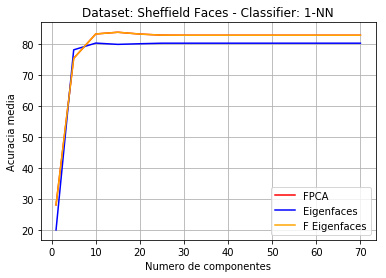

In [121]:
ImprimirResultados(acc_sheffield, "Sheffield Faces")

In [135]:
print("\t+--------------------Yale--------------------+")
print("\t-----FPCA---------Eigenfaces-----F Eigenfaces-")
ImprimirTabela(acc_yale, std_yale)

print("\t---------------------AT&T---------------------")
print("\t-----FPCA---------Eigenfaces-----F Eigenfaces-")
ImprimirTabela(acc_att, std_att)

print("\t------------------Sheffield-------------------")
print("\t-----FPCA---------Eigenfaces-----F Eigenfaces-")
ImprimirTabela(acc_sheffield, std_sheffield)

	+--------------------Yale--------------------+
	-----FPCA---------Eigenfaces-----F Eigenfaces-
1	25.060 +-0.038	26.386 +-0.034	25.060 +-0.038
5	62.289 +-0.067	62.892 +-0.055	62.289 +-0.067
10	66.747 +-0.050	67.952 +-0.055	66.747 +-0.050
15	68.193 +-0.076	69.880 +-0.049	68.193 +-0.076
20	70.964 +-0.065	70.482 +-0.046	70.964 +-0.065
25	74.699 +-0.065	71.687 +-0.046	74.699 +-0.065
30	76.265 +-0.064	71.928 +-0.039	76.265 +-0.064
35	76.145 +-0.067	71.928 +-0.040	76.145 +-0.067
40	77.952 +-0.064	72.410 +-0.038	77.831 +-0.063
45	77.952 +-0.072	72.169 +-0.036	77.952 +-0.072
50	78.554 +-0.069	72.289 +-0.042	78.675 +-0.068
55	78.675 +-0.066	72.771 +-0.044	78.675 +-0.066
60	78.554 +-0.065	72.771 +-0.042	78.554 +-0.065
65	78.795 +-0.068	72.771 +-0.037	78.916 +-0.068
70	78.795 +-0.070	72.651 +-0.038	78.795 +-0.068
	---------------------AT&T---------------------
	-----FPCA---------Eigenfaces-----F Eigenfaces-
1	21.050 +-0.056	15.800 +-0.013	21.050 +-0.056
5	58.700 +-0.021	61.800 +-0.016	58.700 +-0.